In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from PIL import Image
from psycopg2 import connect

In [7]:
credentials_file = pd.read_csv("./pw_felix.csv")
PG_ADRESS = credentials_file["adress"][0]
PG_PORT = credentials_file["port"][0]
PG_USERNAME = credentials_file["username"][0]
PG_PW = credentials_file["password"][0]
PG_DBNAME = credentials_file["dbname"][0]
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=PG_USERNAME,
                        password=PG_PW,
                        ipaddress=PG_ADRESS,
                        port=PG_PORT,
                        dbname=PG_DBNAME))
cnx = create_engine(postgres_str)
conn = connect(
        dbname = PG_DBNAME,
        user = credentials_file["username"][0],
        host = PG_ADRESS,
        password = credentials_file["password"][0],
        # attempt to connect for 3 seconds then raise exception
        connect_timeout = 3
    )
cur = conn.cursor()

## Database structure

### Tables
- activation (access currently prohibited)
- image (accessible)
- label (accessible)
- label_correlations (access currently prohibited)
- mask (accessible)
- multimask (access currently prohibited)
- neuron (access currently prohibited)
- quantile (access currently prohibited)
- scene (access currently prohibited)
- spatial_ref_sys (accessible)

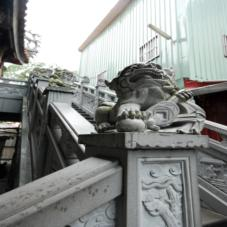

In [27]:
pgImage=pd.read_sql_query('''
    select unnest(ST_Dumpvalues(raster,1)) as r,unnest(ST_Dumpvalues(raster,2)) as g,unnest(ST_Dumpvalues(raster,3)) as b from image where id=9888;
''',cnx)

t=(227,227,3)
A=np.zeros(t,np.uint8)
for i in range(227):
    for j in range (227):
        A[i,j]=[pgImage["r"][i*227+j],pgImage["g"][i*227+j],pgImage["b"][i*227+j]]
        
Image.fromarray(A,"RGB")

In [10]:
cur.execute('''select * into team2.mask_sample from mask TABLESAMPLE system(0.01)''')
conn.commit()

In [8]:
cur.execute(''' INSERT INTO team2.image_sample SELECT id  FROM image TABLESAMPLE bernoulli (1)''')
conn.commit()

In [8]:
cur.execute('''
insert into team2.focus_regions
SELECT neuron_id,image_id,ST_Union(geom) as focus_region
                    FROM (
                            SELECT filteredAct.neuron_id, filteredAct.image_id, quantile, (ST_PixelAsPolygons(ST_SetScale(ST_Resize(activation, 227, 227), 1, -1))).*
                            FROM (select * from activation where image_id=21450 and neuron_id=699) as filteredAct
                            INNER JOIN team2.quantile
                            ON filteredAct.neuron_id = quantile.neuron_id
                            INNER JOIN team2.image_sample
                            ON filteredAct.image_id = team2.image_sample.image_id
                            INNER JOIN neuron_sample
                            ON filteredAct.neuron_id = neuron_sample.neuron_id
                            WHERE level = 0.99
                        ) AS neuron
                    WHERE val >= quantile
                    GROUP BY neuron_id, image_id''')

conn.commit()
cur.close()
conn.close()

In [13]:
cur.execute('''
	insert into team2.IoU
    select avg(IoU), label_id, neuron_id,label_type 
from (
    select label_type, neuron_id,label_id,ST_Area(St_Intersection(region,focus_region)) / ST_Area(ST_Union(region,focus_region)) as IoU
	from (select * from mask TABLESAMPLE SYSTEM (1) where image_id in (select * from team2.image_sample)) as filteredMask
		join team2.focus_regions 
		on team2.focus_regions.image_id = filteredMask.image_id
) as allIoUs
group by label_id, label_type,neuron_id
''')
conn.commit()
cur.close()
conn.close()

In [ ]:
cur.execute()

In [ ]:
pd.read_sql_query('''SELECT name,count(*)
from label 
join mask on label_id = id
group by name
order by count(*) desc;''',cnx)

In [ ]:
pd.read_sql_query('''select name,count(*)
from mask 
join label on label_id = id
where label_type='texture' 
group by name
order by count(*) desc;''',cnx)

In [ ]:
label_types = ["color", "material", "object", "part", "scene", "texture"]

In [ ]:
pd.read_sql_query("select count(*) from image;", cnx)

So it seems that we have 63305 images

In [ ]:
pd.read_sql_query("select region, count(*) from mask TABLESAMPLE SYSTEM(0.01) group by region LIMIT 100;",cnx)

In [ ]:
pd.read_sql_query('''
select avg(ST_Area(region))
from mask 
where label_type='scene'
''',cnx)

In [ ]:
pd.read_sql_query('''
select image_id from mask where label_type='scene'
Except
select image_id from mask where label_type='texture'
''',cnx)

Avg color region size = 46.48709
Avg material region size = 2260.474554
Avg object region size = 1901.260559
Avg part region size = 466.958533
Avg scene region size = 51529.0
Avg texture region size = 51529.0

In [ ]:
region_size = [46.48709,2260.474554,1901.260559,466.958533,51529,51529]
labels = ["Color", "Material", "Object", "Part", "Scene", "Texture"]
plt.bar(labels,region_size)

In [ ]:
pd.read_sql_query('''
SELECT lt1,ln1,lt2,ln2, count(*) as frequency
FROM (
    SELECT m1.image_id, m1.label_type as lt1, label1.name as ln1, m2.label_type as lt2,label2.name as ln2, ST_Distance(m1.region, m2.region) AS min_distance
    FROM mask AS m1 TABLESAMPLE SYSTEM(10) REPEATABLE(1)
    JOIN mask AS m2 TABLESAMPLE SYSTEM(10) REPEATABLE(1)
    ON m1.image_id = m2.image_id
    AND NOT m1.label_id = m2.label_id
    JOIN (SELECT * FROM label WHERE NOT name LIKE '%%-c') AS label1
    ON label1.id = m1.label_id
    JOIN (SELECT * FROM label WHERE NOT name LIKE '%%-c') AS label2
    On label2.id = m2.label_id
    WHERE NOT m1.region = m2.region
    ) as q
GROUP BY lt1,ln1,lt2,ln2
ORDER BY frequency DESC
''',cnx)

In [ ]:
label_positions = pd.read_sql_query(''' 
Select name,ST_X(center),ST_Y(center) from (
    Select name,ST_GeometricMedian(ST_Union(ST_Centroid(region))) as center
    from mask TABLESAMPLE SYSTEM(10) REPEATABLE(1)
    join label 
    on label_id = id
    GROUP BY label_id,name
) as label_positions
''',cnx)

In [ ]:
plt.scatter(label_positions["st_x"],label_positions["st_y"])

In [ ]:
label_positions[label_positions["st_y"]>=0]

In [ ]:
data = pd.read_sql_query('''select ST_AsText(region) from mask limit 500''',cnx)

In [ ]:
data["st_astext"][400]